# MIT-GSL Uruguay 

## January 2020

-----

# Week - 2 | Lesson - 03 
# NLP: Product embeddings in Keras

1. After introducing the concept of embeddings through NLP, we extend the notion of embeddings to other settings
2. Note that embeddings are dense continuous representations for discrete, sparse tokens - this makes embeddings widely applicable
3. We will use the concept of embeddings to understand the world of e-commerce better 

---

# Word2Vec and its Applications to Market-Basket Data

# Instacart Grocery Dataset

### Source: https://www.instacart.com/datasets/grocery-shopping-2017

1. Instacart is an online grocery delivery service
2. They have made available 3M grocery orders for over 200K users
3. They provide between 4 to 100 orders for each user and each order contains the sequence of products purchased
4. We also have a brief description of the products

### Overview:
1. We will use this data to build an understanding of word embeddings and investigate their application to downstream tasks
2. For this purpose, we will consider each purchase basket to be a sentence with an unordered sequence of words

---

# 0. Import Modules

In [65]:
# ==============================================
# 0. Module imports
# ==============================================

import pandas as pd
pd.options.display.max_colwidth = 100
import numpy as np
from itertools import product
import csv
import collections
import random

# w2v
import gensim

# text processing
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import ToktokTokenizer
import string
import re # regular expressions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

# T-Sne
#import umap
#from openTSNE import TSNE, TSNEEmbedding, affinity, initialization
#from openTSNE import initialization
#from openTSNE.callbacks import ErrorLogger
from sklearn.manifold import TSNE


# utils
from sklearn import utils


# parallel processing
import multiprocessing
from joblib import delayed, Parallel

# time code
import time

# 2-d visualiztion
%matplotlib inline
from ggplot import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os

EC2 = True  # If using EC2 (for data directory/paths)

# Select path based off of local or remote
if not EC2:
    wd = "/pool001/madhavk/gsl-uruguay/W-02-NLP/"
else:
    wd = "/home/ubuntu/machine_learning_aws/"
    
os.chdir(wd)


In [2]:
# ===============================================
# keras modules
# ===============================================

from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Reshape, merge, Flatten, Concatenate, Activation, Multiply
from keras.layers.embeddings import Embedding
from keras.layers.merge import dot
from keras.layers.merge import Dot
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras import optimizers
from keras.callbacks import History 
from keras import regularizers

Using TensorFlow backend.


In [3]:
# =========================================================
# set directories
# =========================================================

EC2 = True  # If using EC2 (for data directory/paths)

if not EC2:
    # raw data
    raw_data_dir = "nlp-data/in-grocery/instacart_2017_05_01/"

    # processed data
    process_dir = "nlp-data/in-grocery/prepared-data/"
    
else:
    # raw data
    raw_data_dir = "data/in-grocery/instacart_2017_05_01"

    # processed data
    process_dir = "data/in-grocery/prepared-data/"

In [4]:
#===============================================
# processed files
#===============================================
os.listdir(process_dir)

['orders-split-v1.csv',
 'all-orders-wide-v1.csv',
 'all-orders-long-v1.csv',
 'products-merged-v1.csv']

In [5]:
#===============================================
# global parameters
#===============================================

# show entire value of cell in pandas
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

# number of cpus
cpus = multiprocessing.cpu_count()
f"Number of CPUs: {cpus}"

'Number of CPUs: 28'

---

# 1. Import data

## 1.1. Order level data

In [6]:
# =========================================================
# order-level data
# =========================================================

orders_wide = pd.read_csv(process_dir + "all-orders-wide-v1.csv")
print(orders_wide.shape)

(3152555, 4)


In [7]:
display(orders_wide.head(10))

,order_id,product_id,num_products,eval
0,2,33120 28985 9327 45918 30035 17794 40141 1819,8,prior
1,3,33754 24838 17704 21903 17668 46667 17461 32665,8,prior
2,4,46842 39758 27761 10054 21351 22598 34862 40285 17616 25146 32645 41276,12,prior
3,5,13176 47329 27966 23909 48370 13245 27360 6348 40878 6184 48002 20914 37011 12962 45698 41176 48366 47209 46522 38693 48825 8479,22,prior
4,7,34050 46802,2,prior
5,9,21405 47890 11182 2014 29193 34203 14992 31506 23288 44533 18362 432 3990 14183,14,prior
6,10,24852 4796 31717 47766 4605 1529 21137 22122 34134 27156 14992 49235 26842 3464 25720,15,prior
7,11,30162 5994 1313 31506,4,prior
8,12,30597 15221 43772 37886 37215 34335 26910 38888 38050 29471,10,prior
9,13,17330 27407 35419 196 44635 26878 25783 41290 33198 23020 36086 3800 25952,13,prior


In [8]:
# =========================================================
# orders meta-data
# =========================================================

orders_meta = pd.read_csv(process_dir + "orders-split-v1.csv")
print(orders_meta.shape)

(3346083, 7)


In [9]:
display(orders_meta.head(10))

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval
0,2539329,1,1,2,8,NaN,prior
1,2398795,1,2,3,7,15.0,prior
2,473747,1,3,3,12,21.0,prior
3,2254736,1,4,4,7,29.0,prior
4,431534,1,5,4,15,28.0,prior
5,3367565,1,6,2,7,19.0,prior
6,550135,1,7,1,9,20.0,prior
7,3108588,1,8,1,14,14.0,prior
8,2295261,1,9,1,16,0.0,prior
9,2550362,1,10,4,8,30.0,prior


## 1.2. Merge train-val-test split

In [10]:
# =========================================================
# merge orders-wide and orders-meta
# =========================================================

orders_wide.drop(labels = "eval", axis = 1, inplace = True)

In [11]:
# merge
orders_wide = pd.merge(orders_wide, orders_meta[["order_id", "user_id", "eval"]],
                       on = "order_id", how = "left")
print(orders_wide.shape)

(3152555, 5)


In [12]:
display(orders_wide.head(10))

,order_id,product_id,num_products,user_id,eval
0,2,33120 28985 9327 45918 30035 17794 40141 1819,8,202279,prior
1,3,33754 24838 17704 21903 17668 46667 17461 32665,8,205970,prior
2,4,46842 39758 27761 10054 21351 22598 34862 40285 17616 25146 32645 41276,12,178520,prior
3,5,13176 47329 27966 23909 48370 13245 27360 6348 40878 6184 48002 20914 37011 12962 45698 41176 48366 47209 46522 38693 48825 8479,22,156122,prior
4,7,34050 46802,2,142903,prior
5,9,21405 47890 11182 2014 29193 34203 14992 31506 23288 44533 18362 432 3990 14183,14,139016,prior
6,10,24852 4796 31717 47766 4605 1529 21137 22122 34134 27156 14992 49235 26842 3464 25720,15,135442,prior
7,11,30162 5994 1313 31506,4,143742,prior
8,12,30597 15221 43772 37886 37215 34335 26910 38888 38050 29471,10,152610,prior
9,13,17330 27407 35419 196 44635 26878 25783 41290 33198 23020 36086 3800 25952,13,45082,prior


In [13]:
# =========================================================
# eval-set distribution
# =========================================================

orders_wide["eval"].value_counts()

prior    2959079
train    116333 
val      38701  
test     38442  
Name: eval, dtype: int64

In [14]:
# clear some space
del orders_meta

## 1.3. Import product info data

In [15]:
products = pd.read_csv(process_dir + "products-merged-v1.csv")
print(products.shape)

(49688, 6)


In [16]:
display(products.head(10))

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry
5,6,Dry Nose Oil,11,11,cold flu allergy,personal care
6,7,Pure Coconut Water With Orange,98,7,juice nectars,beverages
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen produce,frozen
8,9,Light Strawberry Blueberry Yogurt,120,16,yogurt,dairy eggs
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,water seltzer sparkling water,beverages


In [17]:
#===============================================
# top departments
#===============================================
products["department"].value_counts()

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets               972 
meat seafood       907 
other              548 
bulk               38  
Name: department, dtype: int64

In [18]:
#===============================================
# top aisles
#===============================================
products["aisle"].value_counts()

missing                          1258
candy chocolate                  1246
ice cream ice                    1091
vitamins supplements             1038
yogurt                           1026
chips pretzels                   989 
tea                              894 
packaged cheese                  891 
frozen meals                     880 
cookies cakes                    874 
energy granola bars              832 
hair care                        816 
spices seasonings                797 
juice nectars                    792 
crackers                         747 
soup broth bouillon              737 
baby food formula                718 
coffee                           680 
refrigerated                     675 
cleaning products                655 
baking ingredients               623 
packaged vegetables fruits       615 
asian foods                      605 
nuts seeds dried fruit           582 
fresh vegetables                 569 
oral hygiene                     565 
salad dressi

----

# 2. Split train-val-test datasets


In [20]:
#===============================================
# split train-val-test
#===============================================

train = orders_wide.loc[orders_wide["eval"].isin(["prior", "train"]), :]
val = orders_wide.loc[orders_wide["eval"] == "val", :]
test = orders_wide.loc[orders_wide["eval"] == "test", :]
print("train size:", train.shape)
print("val size:", val.shape)
print("test size:", test.shape)

train size: (3075412, 5)
val size: (38701, 5)
test size: (38442, 5)


In [21]:
# clear more space
del orders_wide

In [22]:
display(train.head())

,order_id,product_id,num_products,user_id,eval
0,2,33120 28985 9327 45918 30035 17794 40141 1819,8,202279,prior
1,3,33754 24838 17704 21903 17668 46667 17461 32665,8,205970,prior
2,4,46842 39758 27761 10054 21351 22598 34862 40285 17616 25146 32645 41276,12,178520,prior
3,5,13176 47329 27966 23909 48370 13245 27360 6348 40878 6184 48002 20914 37011 12962 45698 41176 48366 47209 46522 38693 48825 8479,22,156122,prior
4,7,34050 46802,2,142903,prior


## 2.1. Random sample for faster processing

In [23]:
#===============================================
# randomly sample training data
#===============================================

sample_size = 1000000
train = train.sample(n = sample_size)
train = train.reset_index(drop = True)
print(train.shape)

(1000000, 5)


In [24]:
display(train.head(10))

,order_id,product_id,num_products,user_id,eval
0,1999082,13176 31720 36550 40145 42533 45123 24385 46665 21903 5876 12456,11,35405,prior
1,2819748,24955 31506 2495 1217 9932 33087 24269 16797 20590 18339,10,205442,prior
2,3074719,27374 4913,2,80357,prior
3,3141838,46023 43510 432 28517 13966,5,140567,prior
4,862568,46105 36011 18232 15892,4,97802,prior
5,199935,28849 45 25890 5024 24830 24852,6,98891,prior
6,839926,39276 397 23405 34024 27096 1485 33331 11827 26571 5985 21524 49054 11281 46572,14,116715,prior
7,1341386,33554 33100 19162,3,116577,train
8,2724046,36724 24852 38689 37947 12745 41757 14992 13083,8,43622,prior
9,644497,21137 29987 21903 16349,4,16554,prior


## 2.2. Tokenize sentences

In [25]:
# start pool process for parallel procressing
pool = multiprocessing.Pool(processes = cpus)

In [26]:
# training sentences
t0 = time.time()
train_orders = pool.map(word_tokenize, train["product_id"])
t1 = time.time()
print(len(train_orders))

1000000


In [27]:
# time taken
f"Time Taken: {t1 - t0}"

'Time Taken: 12.241389751434326'

In [28]:
# training orders
train_orders[0:3]

[['13176',
  '31720',
  '36550',
  '40145',
  '42533',
  '45123',
  '24385',
  '46665',
  '21903',
  '5876',
  '12456'],
 ['24955',
  '31506',
  '2495',
  '1217',
  '9932',
  '33087',
  '24269',
  '16797',
  '20590',
  '18339'],
 ['27374', '4913']]

In [29]:
# validation sentences
t0 = time.time()
val_orders = pool.map(word_tokenize, val["product_id"])
t1 = time.time()
print(len(val_orders))

38701


In [30]:
# test sentences
t0 = time.time()
test_orders = pool.map(word_tokenize, test["product_id"])
t1 = time.time()
print(len(test_orders))

38442


----------

# 3. Writing our own Word2Vec in Keras

## Tasks:
### 1. Count frequency of all words in dataset
     1.1. Used to sample words based on frequency
### 2. Create word-to-index dictionary
    2.1. The index for each word serves as a lookup value in the embedding matrix
    2.2. The dictionary is created in order of frequency
### 3. Convert entire dataset from a sequence of words to a sequences of indices

---

## 3.1. Count frequency of each word in vocabulary

In [31]:
def WordFrequency(train_data, max_words = 10000):
    '''
    Assumes train data is a list of lists
    '''
    train_flat = [item for sublist in train_data for item in sublist] 
    count = [['UNK', -1]]
    count.extend(collections.Counter(train_flat).most_common(max_words))
    return count

In [34]:
# flatten train-orders to create one giant list
word_freq = WordFrequency(train_data = train_orders)
len(word_freq)

10001

In [35]:
# inspect
word_freq[0:5]

[['UNK', -1],
 ('24852', 155767),
 ('13176', 124253),
 ('21137', 86783),
 ('21903', 79382)]

## 3.2. Create Word-to-Index and Index-to-Word dictionaries
### 3.2.1. These are used to create look-up embedding matrices
### 3.2.2. They are ordered as per frequency of the corresponding word in the vocabulary

In [36]:
# create word-index dictionary
def Word2Index(word_count):
    dictionary = dict()
    for word, _ in word_count:
        dictionary[word] = len(dictionary)
    # index-word reveresed dictionary
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reversed_dictionary

In [37]:
word_ix, ix_word = Word2Index(word_count = word_freq)

In [38]:
word_ix

{'UNK': 0,
 '24852': 1,
 '13176': 2,
 '21137': 3,
 '21903': 4,
 '47209': 5,
 '47766': 6,
 '47626': 7,
 '16797': 8,
 '26209': 9,
 '27966': 10,
 '27845': 11,
 '22935': 12,
 '24964': 13,
 '45007': 14,
 '39275': 15,
 '49683': 16,
 '28204': 17,
 '5876': 18,
 '8277': 19,
 '40706': 20,
 '4920': 21,
 '30391': 22,
 '45066': 23,
 '42265': 24,
 '44632': 25,
 '19057': 26,
 '49235': 27,
 '4605': 28,
 '17794': 29,
 '37646': 30,
 '21616': 31,
 '30489': 32,
 '27104': 33,
 '31717': 34,
 '27086': 35,
 '8518': 36,
 '46979': 37,
 '28985': 38,
 '44359': 39,
 '41950': 40,
 '26604': 41,
 '5077': 42,
 '34126': 43,
 '22035': 44,
 '39877': 45,
 '10749': 46,
 '43352': 47,
 '35951': 48,
 '24184': 49,
 '9076': 50,
 '43961': 51,
 '21938': 52,
 '34969': 53,
 '19660': 54,
 '48679': 55,
 '46667': 56,
 '39928': 57,
 '31506': 58,
 '25890': 59,
 '5450': 60,
 '24838': 61,
 '12341': 62,
 '22825': 63,
 '5785': 64,
 '35221': 65,
 '28842': 66,
 '33731': 67,
 '8424': 68,
 '27521': 69,
 '8174': 70,
 '20114': 71,
 '44142': 72,
 

In [39]:
ix_word

{0: 'UNK',
 1: '24852',
 2: '13176',
 3: '21137',
 4: '21903',
 5: '47209',
 6: '47766',
 7: '47626',
 8: '16797',
 9: '26209',
 10: '27966',
 11: '27845',
 12: '22935',
 13: '24964',
 14: '45007',
 15: '39275',
 16: '49683',
 17: '28204',
 18: '5876',
 19: '8277',
 20: '40706',
 21: '4920',
 22: '30391',
 23: '45066',
 24: '42265',
 25: '44632',
 26: '19057',
 27: '49235',
 28: '4605',
 29: '17794',
 30: '37646',
 31: '21616',
 32: '30489',
 33: '27104',
 34: '31717',
 35: '27086',
 36: '8518',
 37: '46979',
 38: '28985',
 39: '44359',
 40: '41950',
 41: '26604',
 42: '5077',
 43: '34126',
 44: '22035',
 45: '39877',
 46: '10749',
 47: '43352',
 48: '35951',
 49: '24184',
 50: '9076',
 51: '43961',
 52: '21938',
 53: '34969',
 54: '19660',
 55: '48679',
 56: '46667',
 57: '39928',
 58: '31506',
 59: '25890',
 60: '5450',
 61: '24838',
 62: '12341',
 63: '22825',
 64: '5785',
 65: '35221',
 66: '28842',
 67: '33731',
 68: '8424',
 69: '27521',
 70: '8174',
 71: '20114',
 72: '44142',
 

## 3.3. Convert entire data set from text to indices


In [40]:
# convert data to index
def Data2Index(train_data, word_ix, ret_unk_cnt = False):
    data = list()
    global unk_count
    unk_count = 0
    for order in train_data:
        ord_data = []
        for word in order:
            if word in word_ix:
                index = word_ix[word]
            else:
                index = 0
                unk_count += 1
            ord_data.append(index)
        data.append(ord_data)
    if ret_unk_cnt:
        return(data, unk_count)
    else:
        return(data)

In [41]:
# training orders
train_orders_ix = Data2Index(train_data = train_orders, word_ix = word_ix, ret_unk_cnt = False)

In [42]:
train_orders[0:3]

[['13176',
  '31720',
  '36550',
  '40145',
  '42533',
  '45123',
  '24385',
  '46665',
  '21903',
  '5876',
  '12456'],
 ['24955',
  '31506',
  '2495',
  '1217',
  '9932',
  '33087',
  '24269',
  '16797',
  '20590',
  '18339'],
 ['27374', '4913']]

In [43]:
train_orders_ix[0:3]

[[2, 493, 315, 6315, 3904, 392, 2676, 3644, 4, 18, 358],
 [3624, 58, 6492, 1376, 3424, 8405, 4549, 8, 2512, 1339],
 [0, 5342]]

In [44]:
# total number of training orders
len(train_orders)

1000000

In [45]:
# val orders
val_orders_ix = Data2Index(train_data = val_orders, word_ix = word_ix, ret_unk_cnt = False)
print(len(val_orders_ix))

# test orders
test_orders_ix = Data2Index(train_data = test_orders, word_ix = word_ix, ret_unk_cnt = False)
print(len(test_orders_ix))

38701
38442


---

# 4. Define embedding matrices and model


## 4.1. Model parameters

In [46]:
# embedding parameters
vocab_size = len(word_ix)
input_size = vocab_size
emb_size = 100

In [47]:
# size of vocabulary
f"Vocab size: {vocab_size}"

'Vocab size: 10001'

## 4.2. Embedding layers
### We use two embedding layers -- one for the target product and one for the context product

In [48]:
# define input layers
input_target = Input((1,))
input_context = Input((1,))

In [49]:
# define embedding layers

# target
target = Embedding(input_dim = vocab_size, output_dim= emb_size, name = "rho")(input_target)
target = Reshape(target_shape = (emb_size, 1))(target)

# context
context = Embedding(input_dim = vocab_size, output_dim= emb_size, name = "alpha")(input_context)
context = Reshape(target_shape = (emb_size, 1))(context)

In [50]:
# concatenate model inputs and outputs
input_model = [input_target, input_context]

In [51]:
output_embeddings = Dot(axes = 1)([target, context])
output_embeddings

<tf.Tensor 'dot_1/MatMul:0' shape=(?, 1, 1) dtype=float32>

In [52]:
# resize embeddings
#output_model = Reshape((1,))(output_embeddings)
output_model = Flatten()(output_embeddings)
output_model

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>

In [53]:
# complete model
output_model = Dense(1, activation = "sigmoid")(output_model)

## 4.3. Complete model

In [54]:
# define as keras model
pemb_model = Model(inputs = input_model, outputs = output_model)

In [55]:
# optimizer
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)

In [56]:
# compile model
pemb_model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['acc'])

In [57]:
# model summary
pemb_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
rho (Embedding)                 (None, 1, 100)       1000100     input_1[0][0]                    
__________________________________________________________________________________________________
alpha (Embedding)               (None, 1, 100)       1000100     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

----

# 5. Initial product embeddings

In [58]:
# initial weights - rho
init_rho = pemb_model.get_layer("rho").get_weights()[0]
print(init_rho.shape)

(10001, 100)


In [59]:
# initial weights - alpha
init_alpha = pemb_model.get_layer("alpha").get_weights()[0]
print(init_alpha.shape)

(10001, 100)


----

# 6. Prepare batches for model

In [60]:
# sampling table
sampling_table = sequence.make_sampling_table(vocab_size)

In [61]:
# context size and negative samples
ns = 10.0
cs = 5

In [62]:
def BatchGenerator(training = True):
    i = 0
    while True:
        if training:
            order_data = random.sample(train_orders_ix, batch_size)
        else:
            order_data = random.sample(val_orders_ix, batch_size)
        iv = []
        dv =[]
        for d in order_data:
            couples, labels = skipgrams(d, vocabulary_size = vocab_size, window_size = cs,
                                        negative_samples = ns, sampling_table = sampling_table)
            iv = iv + couples
            dv = dv + labels
        i += 1
        X = np.array(iv, dtype = "int32")
        X = [X[:, 0], X[:, 1]]
        yield X, dv

In [63]:
# parameters
batch_size = 64
num_epochs = 1

# training data generator
train_gen = BatchGenerator(training = True)

# validation data generator
val_gen = BatchGenerator(training = False)

# history
history = History()

----

# 7. Train model
### This could take a while

In [66]:
# train model
t0 = time.time()
pemb_model.fit_generator(generator = train_gen, 
                         steps_per_epoch = len(train_orders_ix)//batch_size,
                         epochs = num_epochs,
                         workers = cpus, 
                         use_multiprocessing = True, 
                         validation_data = val_gen,
                         validation_steps = len(val_orders_ix)//batch_size,
                         callbacks = [history])
t1 = time.time()

Epoch 1/1
15625/15625 [==============================] - 261s 17ms/step - loss: 0.2110 - acc: 0.9242 - val_loss: 0.2073 - val_acc: 0.9246


In [67]:
# time taken
t1 - t0

261.96698117256165

In [68]:
# history
history.history

{'val_loss': [0.20734344827604587],
 'val_acc': [0.9245526657010128],
 'loss': [0.21120006831971477],
 'acc': [0.9241395524830877]}

------

# 8. Model results

In [69]:
# final weights - target words
final_rho = pemb_model.get_layer("rho").get_weights()[0]

In [70]:
# final weights - context words
final_alpha = pemb_model.get_layer("alpha").get_weights()[0]

In [71]:
init_rho[61]

array([ 0.02483419,  0.00277738, -0.03695145,  0.03737691,  0.02650872,
        0.00134617,  0.02473993, -0.0204855 ,  0.04731424, -0.01627402,
        0.0208024 , -0.02845646, -0.02032243, -0.0307878 , -0.03762526,
        0.02517292, -0.00458949, -0.03826829, -0.00173398,  0.03717914,
       -0.04961249, -0.03364372, -0.01735036, -0.03700382, -0.01398521,
       -0.0207876 ,  0.02495605, -0.0087539 ,  0.02424939, -0.01305704,
        0.04341017,  0.0400443 , -0.048185  , -0.01605556,  0.0055742 ,
       -0.03548105,  0.01553322, -0.03047293, -0.03946618,  0.01376722,
        0.0046767 ,  0.01011919, -0.03349251, -0.00917793, -0.02600352,
       -0.03023951,  0.04654651, -0.0023563 , -0.00262531,  0.03351593,
        0.0414421 , -0.02964205,  0.00848329, -0.0038226 ,  0.0332169 ,
       -0.03692532, -0.02344103, -0.02383323,  0.03610642,  0.01707374,
       -0.02269268,  0.01784459, -0.04556118,  0.02005554,  0.00374743,
        0.02347514, -0.0014537 , -0.02620796, -0.01942527, -0.03

In [72]:
final_rho[61]

array([ 1.0170135 ,  1.2472743 , -0.90052193, -0.4948235 ,  0.4961027 ,
       -0.62443244,  1.006072  ,  1.3652294 , -0.09854615, -1.0414069 ,
        0.8958653 ,  0.06016276,  0.42853862,  0.6913274 ,  0.6295234 ,
        0.18089883, -0.33555356, -0.6572056 ,  0.14797054, -0.12665717,
       -0.6041674 ,  0.25888202,  0.71191925,  0.45959318, -0.03240573,
       -0.93035346, -0.9720278 , -0.6175317 ,  0.01774108, -0.79513323,
        1.3761443 ,  1.0101174 , -0.06203645,  1.2365018 ,  0.21995237,
       -1.8677027 , -0.07510675, -0.51832944,  0.76881   , -1.7511042 ,
        0.58923423, -0.43200094, -0.78326803,  1.0231295 ,  1.2821386 ,
        0.36230466,  1.0982318 , -0.47517407, -1.5319707 , -0.12401051,
       -0.23574317,  0.3201767 ,  1.4202112 , -1.0006183 , -0.59967256,
        0.33493745, -1.2872891 ,  0.6410114 ,  0.8741236 ,  1.0034208 ,
       -0.25304934, -0.68911505,  0.7112612 , -0.6725843 , -0.39164767,
       -0.78549594,  1.3420101 ,  0.6333844 , -0.44146043,  0.03

In [73]:
#===============================================
# extract embeddings to data frame
#===============================================

def EmbToDataFrame(ix_word, emb_mat, col_prefix = "rho"):
    emb_df = {ix_word[i]: list(emb_mat[i]) for i in ix_word.keys()}
    emb_df = pd.DataFrame.from_dict(emb_df, orient = "columns")
    emb_df = emb_df.transpose().reset_index(drop = False)
    emb_df.columns = ["product_id"] + [col_prefix + str(i + 1) for i in range(emb_df.shape[1] - 1)]
    return emb_df

In [74]:
# get data frame from rho matrix
rho_df = EmbToDataFrame(ix_word, emb_mat = final_rho, col_prefix = "rho")
display(rho_df.head())

,product_id,rho1,rho2,rho3,rho4,rho5,rho6,rho7,rho8,rho9,rho10,rho11,rho12,rho13,rho14,rho15,rho16,rho17,rho18,rho19,rho20,rho21,rho22,rho23,rho24,rho25,rho26,rho27,rho28,rho29,rho30,rho31,rho32,rho33,rho34,rho35,rho36,rho37,rho38,rho39,rho40,rho41,rho42,rho43,rho44,rho45,rho46,rho47,rho48,rho49,rho50,rho51,rho52,rho53,rho54,rho55,rho56,rho57,rho58,rho59,rho60,rho61,rho62,rho63,rho64,rho65,rho66,rho67,rho68,rho69,rho70,rho71,rho72,rho73,rho74,rho75,rho76,rho77,rho78,rho79,rho80,rho81,rho82,rho83,rho84,rho85,rho86,rho87,rho88,rho89,rho90,rho91,rho92,rho93,rho94,rho95,rho96,rho97,rho98,rho99,rho100
0,1,-1.407297,0.196761,2.843843,0.527403,0.367157,-1.453686,-0.311064,-0.141496,0.090727,1.358822,-0.807941,-0.867931,2.563112,0.619243,1.614364,-0.856632,0.419146,1.135998,-1.885272,2.062891,-1.879288,1.187180,0.544301,-4.889042,0.358344,-0.260342,-1.660831,-2.193299,-0.031717,-1.300867,0.542401,-1.487911,0.990646,0.503627,-1.673321,-0.642400,-2.115922,1.673579,0.711604,2.624341,1.255499,-0.580955,-0.969040,0.003223,-1.350839,0.769744,0.137348,-0.608863,0.242836,0.838286,0.655919,-2.594806,-1.465429,-0.974696,0.043207,2.841821,-0.205926,0.145827,-2.523647,1.203160,0.942731,-0.735569,0.795591,-0.459932,-0.270043,-0.930904,-0.711659,1.203405,-0.402639,-0.454368,-0.205399,1.007449,0.950822,1.655827,-1.681936,-1.130926,0.043124,1.011280,-0.370117,0.042753,-1.160807,-3.233725,-0.042361,-0.771750,-0.702324,3.666888,-1.291571,-2.306432,-0.355056,-1.471654,-0.356760,2.237108,1.826911,1.265073,-0.067128,-1.861842,-0.524676,-0.035982,-1.087474,-1.165626
1,10,1.188207,0.240927,-1.269330,-0.595818,0.771068,-0.195078,0.938431,-0.375201,1.014311,-0.171243,-0.862915,0.431541,-0.056413,0.132980,-0.618820,2.372569,-1.011636,-0.352976,2.461897,0.182863,-1.788482,0.742933,-0.711138,-2.081859,-0.161754,-0.119665,0.395807,-0.632828,0.087962,-1.461347,0.075045,1.103155,-0.710256,-0.614041,-1.034166,-1.053855,1.214114,0.070942,0.451714,-1.238979,-0.087912,-0.559601,-0.992558,1.023524,0.400891,0.059312,0.829457,0.010744,0.400277,1.361023,1.472040,-1.652562,0.823812,-0.358828,-1.035905,-0.325068,-1.633540,2.068033,-0.683797,-1.036426,1.063284,-0.685887,1.020718,0.216679,-1.310863,-0.942768,0.850113,1.247700,-0.728492,-2.424098,-0.002780,-0.087945,-0.808083,-0.231017,-0.586595,-1.806542,-0.986781,-0.006761,0.840862,-1.273550,-0.731110,-0.125855,1.208264,1.577242,-0.446595,-0.174115,-1.567385,-0.547728,-0.402703,-1.511153,0.276304,1.000041,-0.932309,1.313724,0.836105,0.781615,-0.422282,0.621242,-1.394814,-2.001218
2,100,-0.272002,0.263909,-0.158097,-0.552360,0.189324,-1.711761,1.280256,-0.109544,2.772735,0.677477,0.575259,-0.513616,1.130553,0.254512,0.528868,-0.754199,1.254828,-0.148056,-1.407852,-0.224793,-0.371252,-0.513655,-0.029064,-0.016365,-2.784047,-0.556877,0.178392,-1.284082,-1.164965,0.513416,-0.137338,-0.853260,-0.729953,0.643025,-0.589074,-0.757747,-0.367652,-0.556181,0.517873,2.377795,0.551738,-0.179979,2.964639,1.451775,-1.252250,-1.100777,1.456730,-0.213038,-0.946519,0.687618,-1.276965,-2.504478,-1.356383,0.134022,-0.391058,1.963944,0.287902,0.150411,-1.299954,-0.550078,0.032066,0.003078,0.504621,1.085775,-0.652954,-0.917129,-0.291849,-0.680765,0.722620,0.668114,-0.033009,0.675313,0.671281,-0.026620,1.076582,-0.588111,-3.061903,0.757933,-0.340757,0.073433,-0.970334,-1.633856,-0.386110,-0.184293,-0.301961,2.405254,-1.657157,0.534252,-0.464277,0.172869,-0.074716,0.625611,2.975983,1.612262,0.120111,-1.116509,0.348659,-0.138802,0.193330,0.200396
3,1000,-2.010556,0.795838,-0.042724,0.742042,1.211749,-0.806089,-0.126554,1.791515,-1.416879,0.369412,0.290217,-0.697921,2.471885,0.296962,0.086753,0.246073,0.057949,-0.905595,0.392540,2.172077,-0.785387,0.986720,0.999908,-2.304924,0.889919,-1.126584,-1.351045,-1.980653,0.205228,-1.313341,0.218765,-1.624316,0.779055,1.146600,-0.695709,-0.520188,-0.429508,0.556167,0.743725,-0.540139,0.763700,0.056077,-2.163025,0.774288,-0.423628,0.076485,0.230076,-1.490216,0.188707,1.015221,0.383525,0.008715,-0.359060,-1.8937

In [75]:
# get data frame from alpha matrix
alpha_df = EmbToDataFrame(ix_word, emb_mat = final_alpha, col_prefix = "alpha")
display(alpha_df.head())

,product_id,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,alpha12,alpha13,alpha14,alpha15,alpha16,alpha17,alpha18,alpha19,alpha20,alpha21,alpha22,alpha23,alpha24,alpha25,alpha26,alpha27,alpha28,alpha29,alpha30,alpha31,alpha32,alpha33,alpha34,alpha35,alpha36,alpha37,alpha38,alpha39,alpha40,alpha41,alpha42,alpha43,alpha44,alpha45,alpha46,alpha47,alpha48,alpha49,alpha50,alpha51,alpha52,alpha53,alpha54,alpha55,alpha56,alpha57,alpha58,alpha59,alpha60,alpha61,alpha62,alpha63,alpha64,alpha65,alpha66,alpha67,alpha68,alpha69,alpha70,alpha71,alpha72,alpha73,alpha74,alpha75,alpha76,alpha77,alpha78,alpha79,alpha80,alpha81,alpha82,alpha83,alpha84,alpha85,alpha86,alpha87,alpha88,alpha89,alpha90,alpha91,alpha92,alpha93,alpha94,alpha95,alpha96,alpha97,alpha98,alpha99,alpha100
0,1,0.859411,1.308735,-1.113261,0.439584,1.183388,-0.701481,4.152917,1.816046,1.629143,0.829013,-1.945819,-0.300911,-0.908272,1.316261,0.487781,3.277828,-3.653708,-1.695062,1.758948,-0.191698,-0.388802,-0.458721,0.958611,1.679513,-1.315966,-0.007811,0.284157,1.133534,-1.286173,0.138992,1.471451,2.056872,0.616739,0.239034,0.788530,-0.333758,1.630513,-1.801683,0.048676,-2.357347,-0.886644,-0.980239,1.552652,1.915320,0.702248,0.943043,1.447849,-0.533523,-3.161102,-0.003728,-1.551361,2.127568,3.297548,-0.495269,0.082743,-0.751076,-1.023140,1.992330,0.093109,-0.166104,0.526056,0.003831,0.498811,-2.383196,0.296811,-0.587833,0.958682,0.586220,-1.668903,-2.780305,-2.387594,-0.672226,-0.045907,0.280158,-0.750203,0.415323,-0.950970,-1.885684,-1.012604,-0.805893,0.157321,1.238590,3.727454,1.443371,-1.933987,-0.285756,0.521189,0.212147,-1.316339,1.246664,-1.631388,-0.347362,-0.078500,-3.414556,0.864299,0.270213,-1.279978,1.232477,0.153663,-0.439284
1,10,-1.246225,-0.397327,0.497176,0.506154,0.048750,-1.828015,0.117270,0.920653,0.232346,0.573206,0.284885,-1.116718,-0.509759,-0.092105,1.114250,-0.914972,-0.154757,0.785156,-1.899964,0.187883,0.998809,-0.087060,1.533135,0.570048,-0.967291,-1.360351,-3.165292,-1.052768,-1.549373,0.350436,1.009274,0.115436,0.925362,-0.238170,-0.136264,-0.021474,-1.794875,-1.997627,1.173071,1.091250,0.428661,0.758517,3.003340,-0.279769,-0.397688,0.128185,0.554712,0.135924,-0.927284,-0.347264,-0.349802,1.817613,0.042135,-0.602202,-0.876169,0.356252,1.115844,-0.702026,-0.448219,1.536201,-0.309162,0.899802,-0.432823,-0.635322,0.303500,-0.739423,-0.438320,0.138393,-0.120521,0.977064,-1.201369,0.067589,1.316535,0.554386,-0.754548,1.246649,0.028051,-0.157752,-0.777363,0.909038,-0.242628,0.291818,-0.199916,-0.220347,-1.052805,1.229658,-0.401995,-0.606834,-0.285146,3.498831,-0.195702,-1.275871,2.138710,-1.835849,-0.112896,-0.708911,-0.486363,0.414952,0.658982,-0.048459
2,100,-0.895880,1.619160,0.751632,1.698834,0.749343,-0.744914,0.178087,1.453695,-0.170020,1.053113,-2.002965,-1.747628,-0.122459,1.938708,0.626605,2.575156,-2.403221,-1.368293,2.357768,1.827256,-1.281649,2.352925,1.775028,-1.658204,0.781430,-0.682695,-1.061650,-0.018425,-0.871271,-1.417275,2.256142,1.720504,2.111898,1.166563,-1.177327,-0.971264,1.039241,-0.046086,0.716242,-2.193099,-0.198536,-1.197927,-0.886003,0.047134,1.905580,1.225104,0.643173,-0.966142,-1.774918,0.969061,0.023893,2.235574,3.427365,-1.840279,-0.555178,-0.029709,-2.586215,0.839184,-0.777467,1.725108,0.349662,-0.957686,1.734713,-3.364131,-0.064750,-1.650495,1.214038,0.536358,-1.932081,-1.577591,-1.050147,0.146288,0.176463,0.527029,-1.779583,0.449160,0.358712,-1.456887,-1.716001,-1.508030,-0.354649,0.679263,0.947521,1.153474,-0.316048,-0.584639,-0.766081,-2.261079,-0.513176,0.570604,-2.296988,1.744574,-1.148948,-1.911854,1.272644,0.152762,-1.773622,2.510717,-1.492028,-1.184528
3,1000,1.483521,-0.096690,-0.022812,0.270232,-0.057381,-0.478054,0.493858,-0.211593,3.115942,0.995872,-0.598804,-0.268593,-0.402876,0.506492,0.744949,0.573774,-0.702930,-0.040348,0.007992,-0.413871,-0.413065,0.139216,1.213507,1.458314,-2.757125,0.015582,0.134607,0.496385,-0.846821,-0.218408,0.170698,1.296153,0.329214,0.128483,-

## 8.1. Compute similarity between products

In [76]:
#===============================================
# similarity in rho matrix
#===============================================

rho_sim = cosine_similarity(rho_df.iloc[:, 1:])
rho_sim = pd.DataFrame(rho_sim)
rho_sim.reset_index(inplace = True, drop = True)
rho_sim.index = list(rho_df["product_id"].values)
rho_sim.columns = list(rho_df["product_id"].values)
display(rho_sim.head())

,1,10,100,1000,10005,10006,10017,10025,1003,10032,10036,10049,1005,10054,1006,10060,10070,10080,10082,10084,10089,10096,10102,10106,10107,10108,10111,10112,10114,10117,10121,10125,10126,10129,10130,10132,10145,10151,10163,10166,1017,10172,10173,10176,10180,10181,10189,10193,10199,10210,10212,10221,10227,10234,10235,10240,10241,10243,10246,10248,1025,10251,10255,10258,10275,10279,10291,10292,10296,10301,10305,10306,10307,10310,10312,10314,10315,10321,10326,10331,10333,10335,10337,10339,10341,10342,10343,10346,1035,10350,10351,10358,10365,10369,10371,10374,10385,10387,10388,1039,10402,10403,10407,10409,10411,10421,10423,10424,10441,10447,10448,10453,10460,10467,10468,10469,10473,10476,10478,10479,10481,10482,10490,10492,10494,10498,10499,10500,10504,10509,10514,10517,10518,10521,10527,10528,10529,10537,10540,10545,10549,10551,10558,10565,10568,1057,10574,10580,10586,10599,106,10602,10603,10605,10607,10612,10613,10616,1062,10621,1063,10637,10644,10655,10662,10667,10668,10673,10676,10685,1069,10690,10691,10699,10702,10709,10711,10715,10724,1073,10732,10734,10737,10749,10753,10755,1076,10761,10763,10765,10768,10793,10798,1080,10804,10807,10814,10819,10823,10826,10827,10831,10834,10840,10849,10851,1086,10862,10863,10866,10867,10869,1087,10872,10874,10880,10885,10890,10892,10895,1090,10902,10904,10908,10912,10915,10933,1094,10957,1096,10960,10970,10978,10984,1099,10990,10991,10992,10995,10998,11000,11005,11006,11009,11014,11023,1103,11030,1104,11046,...,8912,8920,8923,8928,8929,8940,895,8952,8953,8955,8956,8958,8959,8968,8986,8988,8993,8996,8997,9000,9006,9007,9009,9018,9020,9028,9036,9038,9047,9051,9058,9060,9065,9067,9068,907,9071,9075,9076,9077,9080,9088,9092,9098,9101,9106,9120,9122,9124,9127,913,9130,9133,9137,9138,9139,9154,9155,9159,9162,9166,9170,9171,9172,9175,9176,9177,9178,9186,9189,9194,9199,920,9203,9208,9210,9213,9216,9224,9225,9243,9252,9261,9266,927,9270,928,9284,9285,9290,9292,93,932,9322,9324,9327,9337,9339,9340,9346,9358,9360,9363,9364,9365,9366,937,9372,9373,9383,9385,9387,9389,939,9390,9397,94,940,9405,9407,9409,941,9411,9420,9421,9422,9424,9426,9430,9434,9436,9438,9444,945,9450,9458,9463,9471,9472,9477,9480,9484,9486,9493,9494,9497,95,9505,9507,9510,9513,9515,9517,9519,952,9521,9531,9532,9533,9534,9544,9547,9550,9551,9554,9558,9561,9583,9584,9587,9594,9595,9597,9598,9601,9604,9605,961,9618,9621,9623,9631,9634,9637,9639,9641,9644,9648,9666,9681,9687,9689,9694,9698,9703,972,9725,9736,9739,9741,9743,9755,9762,9766,9772,9776,9779,9781,9783,9786,9788,9796,9799,9804,9807,9808,9810,9825,9829,9836,9837,9838,9839,9849,9852,9853,9862,9864,9866,9871,9881,9883,9885,9886,9894,9896,99,990,9901,9906,9913,9932,9934,994,9955,9963,9964,9972,9996,UNK
1,1.000000,0.151281,0.413642,0.470129,0.046880,-0.037119,-0.016730,0.060782,0.067891,0.246381,0.125628,0.290444,0.244328,0.242331,0.130231,0.035163,0.147393,-0.078070,-0.091772,0.147058,0.162682,0.076514,0.341592,0.000341,0.268134,0.173653,0.015233,-0.003605,0.142351,0.405965,0.070827,0.035580,0.037147,0.082313,0.005904,0.039675,0.314621,0.108211,-0.014271,0.003567,0.143312,0.076774,0.379512,0.064342,0.033539,0.137074,0.069837,0.182267,-0.014065,0.127354,0.031594,0.118930,0.808972,0.070908,0.337043,0.293346,0.315875,0.038815,0.084632,0.062409,0.131986,0.166547,0.237515,0.791133,0.278412,0.278227,0.006505,0.125337,0.211326,0.111017,0.025038,0.047057,-0.099729,0.861597,0.205863,0.078249,0.008339,0.262344,0.730771,0.109732,0.418355,0.323280,0.015900,0.219796,0.181811,0.120406,-0.049588,0.175232,0.039222,0.348847,0.087003,-0.149434,0.322927,0.104637,0.600417,0.195857,0.067842,-0.125701,0.024714,0.053907,0.155915,0.181789,0.189820,0.045377,0.105638,0.202010,-0.084798,0.222349,0.780351,0.060152,0.248973,0.266553,-0.019684,0.035971,0.226337,-0.031821,0.579813,-0.092434,0.258660,0.311794,0.080777,0.033746,-0.113562,0.079415,0.025970,0.605871,0.039596,0.225527,0.050135,0.825981,0.187684,0.068165,0.149141,0.077413,0.196529,0.036588,0.077286,0.031815,0.107983,0.019574,0.285943,0.133941,0.120063,

In [77]:
#===============================================
# similarity in alpha matrix
#===============================================

alpha_sim = cosine_similarity(alpha_df.iloc[:, 1:])
alpha_sim = pd.DataFrame(alpha_sim)
alpha_sim.reset_index(inplace = True, drop = True)
alpha_sim.index = list(alpha_df["product_id"].values)
alpha_sim.columns = list(alpha_df["product_id"].values)
display(alpha_sim.head())

,1,10,100,1000,10005,10006,10017,10025,1003,10032,10036,10049,1005,10054,1006,10060,10070,10080,10082,10084,10089,10096,10102,10106,10107,10108,10111,10112,10114,10117,10121,10125,10126,10129,10130,10132,10145,10151,10163,10166,1017,10172,10173,10176,10180,10181,10189,10193,10199,10210,10212,10221,10227,10234,10235,10240,10241,10243,10246,10248,1025,10251,10255,10258,10275,10279,10291,10292,10296,10301,10305,10306,10307,10310,10312,10314,10315,10321,10326,10331,10333,10335,10337,10339,10341,10342,10343,10346,1035,10350,10351,10358,10365,10369,10371,10374,10385,10387,10388,1039,10402,10403,10407,10409,10411,10421,10423,10424,10441,10447,10448,10453,10460,10467,10468,10469,10473,10476,10478,10479,10481,10482,10490,10492,10494,10498,10499,10500,10504,10509,10514,10517,10518,10521,10527,10528,10529,10537,10540,10545,10549,10551,10558,10565,10568,1057,10574,10580,10586,10599,106,10602,10603,10605,10607,10612,10613,10616,1062,10621,1063,10637,10644,10655,10662,10667,10668,10673,10676,10685,1069,10690,10691,10699,10702,10709,10711,10715,10724,1073,10732,10734,10737,10749,10753,10755,1076,10761,10763,10765,10768,10793,10798,1080,10804,10807,10814,10819,10823,10826,10827,10831,10834,10840,10849,10851,1086,10862,10863,10866,10867,10869,1087,10872,10874,10880,10885,10890,10892,10895,1090,10902,10904,10908,10912,10915,10933,1094,10957,1096,10960,10970,10978,10984,1099,10990,10991,10992,10995,10998,11000,11005,11006,11009,11014,11023,1103,11030,1104,11046,...,8912,8920,8923,8928,8929,8940,895,8952,8953,8955,8956,8958,8959,8968,8986,8988,8993,8996,8997,9000,9006,9007,9009,9018,9020,9028,9036,9038,9047,9051,9058,9060,9065,9067,9068,907,9071,9075,9076,9077,9080,9088,9092,9098,9101,9106,9120,9122,9124,9127,913,9130,9133,9137,9138,9139,9154,9155,9159,9162,9166,9170,9171,9172,9175,9176,9177,9178,9186,9189,9194,9199,920,9203,9208,9210,9213,9216,9224,9225,9243,9252,9261,9266,927,9270,928,9284,9285,9290,9292,93,932,9322,9324,9327,9337,9339,9340,9346,9358,9360,9363,9364,9365,9366,937,9372,9373,9383,9385,9387,9389,939,9390,9397,94,940,9405,9407,9409,941,9411,9420,9421,9422,9424,9426,9430,9434,9436,9438,9444,945,9450,9458,9463,9471,9472,9477,9480,9484,9486,9493,9494,9497,95,9505,9507,9510,9513,9515,9517,9519,952,9521,9531,9532,9533,9534,9544,9547,9550,9551,9554,9558,9561,9583,9584,9587,9594,9595,9597,9598,9601,9604,9605,961,9618,9621,9623,9631,9634,9637,9639,9641,9644,9648,9666,9681,9687,9689,9694,9698,9703,972,9725,9736,9739,9741,9743,9755,9762,9766,9772,9776,9779,9781,9783,9786,9788,9796,9799,9804,9807,9808,9810,9825,9829,9836,9837,9838,9839,9849,9852,9853,9862,9864,9866,9871,9881,9883,9885,9886,9894,9896,99,990,9901,9906,9913,9932,9934,994,9955,9963,9964,9972,9996,UNK
1,1.000000,0.160921,0.631358,0.470603,0.242056,0.004833,-0.217822,0.150324,0.288972,0.101336,0.064639,0.313876,0.355958,0.418619,0.108167,0.053542,-0.149866,0.180833,0.341797,0.363826,0.203827,0.406003,0.604269,-0.215047,0.409791,0.153041,0.283313,0.233166,0.380392,0.654424,0.126044,0.024161,0.259608,0.456352,0.314512,-0.504425,0.450037,0.069801,0.148795,0.277440,0.146635,0.193751,0.549290,0.388824,0.165094,0.345589,0.450085,0.146053,-0.068581,0.357898,0.122401,0.383274,0.780134,0.326874,0.571259,0.539792,0.390071,0.156977,-0.433665,0.115453,-0.278680,0.391094,0.434146,0.762079,0.507224,0.336300,0.335510,0.266646,0.374694,0.265147,-0.216053,0.491799,0.440322,0.824395,0.137427,0.309321,0.257394,0.398545,0.593739,0.370924,0.497524,0.609956,0.114780,0.009783,0.300150,0.317404,-0.017047,0.410376,0.296144,0.487884,0.208551,0.340067,0.437877,-0.053971,0.653837,0.197881,-0.115416,0.218300,0.234575,0.173273,0.471658,0.498499,0.364222,0.290302,0.443589,0.435487,0.285825,0.345435,0.809954,0.422469,0.388981,0.497740,0.339160,0.107957,0.449533,0.245552,0.438156,0.346111,0.519020,0.517339,0.411036,0.168568,0.209921,-0.002471,0.264511,0.714819,0.337135,0.515545,-0.318485,0.794254,0.364699,0.445191,0.150811,0.255161,0.469294,0.162743,0.340954,0.383946,0.322291,0.225991,0.495508,0.247627,0.319562,0.1

In [78]:
# compute similarity
def ComputeProductSimilarity(prod_id, rho_sim, top = 5, include_prod_info = True):
    sim = rho_sim.loc[:, prod_id]
    sim = sim.sort_values(ascending = False)
    sim = sim[1:][0:top]
    sim = pd.DataFrame({"product_id" : list(sim.index), "score": sim}, index = None)
    if include_prod_info:
        sim = products.loc[products["product_id"].isin(sim["product_id"]), ["product_id", "product_name"]]
    return sim

In [79]:
prod_id = "17758"
products.loc[products["product_id"].isin([prod_id]), "product_name"]

17757    Strawberry Rhubarb Yoghurt
Name: product_name, dtype: object

In [80]:
ComputeProductSimilarity(prod_id = prod_id, rho_sim = alpha_sim, top = 10, include_prod_info = True)

,product_id,product_name
11511,11512,Honey Yoghurt
17182,17183,Peach Yoghurt
22150,22151,Tart Cherry Yoghurt
31214,31215,Lemon Yogurt
34992,34993,Mango Yoghurt
36188,36189,Key Lime Yoghurt
40197,40198,Blueberry Yoghurt
46885,46886,Raspberry Yoghurt
49246,49247,Coconut Yoghurt
49627,49628,Yoghurt Blueberry


----

# Class exercise - training embeddings

In [81]:
# Please train embeddings with the following specifcations
# embedding size = 50
# negative samples = 12
# context size = 8
# optimizer = rmsprop
# optimizer learning rate = 0.025
# batch size = 128
# epochs = 1

In [ ]:
####### You are welcome to use the following skeleton code


# define input layers
input_target = Input((1,))
input_context = Input((1,))

# define embedding layers

# target
target = Embedding(input_dim = vocab_size, output_dim= emb_size, name = "rho")(input_target)
target = Reshape(target_shape = (emb_size, 1))(target)

# context
context = Embedding(input_dim = vocab_size, output_dim= emb_size, name = "alpha")(input_context)
context = Reshape(target_shape = (emb_size, 1))(context)

# concatenate model inputs and outputs
input_model = [input_target, input_context]

output_embeddings = Dot(axes = 1)([target, context])
output_embeddings

# resize embeddings
#output_model = Reshape((1,))(output_embeddings)
output_model = Flatten()(output_embeddings)
output_model

# complete model
output_model = Dense(1, activation = "sigmoid")(output_model)

# define as keras model
new_model = Model(inputs = input_model, outputs = output_model)

# optimizer
#### rmsprop

# compile model
# new_model.compile(optimizer = xxxx, loss = 'binary_crossentropy', metrics = ['acc'])

# model summary
# new_model.summary()

--------

# 9. Product maps using t-sne 

## Merge product vectors with product info

In [82]:
#===============================================
# column formats
#===============================================

rho_df["product_id"] = rho_df["product_id"].astype(str)
products["product_id"] = products["product_id"].astype(str)

In [83]:
#===============================================
# merge relevant columns
#===============================================

# relevant columns from product info
prod_info_cols = ["product_id", "product_name", "department", "aisle"]

# merge
word_vec_df = pd.merge(products[prod_info_cols], rho_df, on = "product_id", how = "inner")
print(word_vec_df.shape)

(10000, 104)


In [84]:
display(word_vec_df.head(10))

,product_id,product_name,department,aisle,rho1,rho2,rho3,rho4,rho5,rho6,rho7,rho8,rho9,rho10,rho11,rho12,rho13,rho14,rho15,rho16,rho17,rho18,rho19,rho20,rho21,rho22,rho23,rho24,rho25,rho26,rho27,rho28,rho29,rho30,rho31,rho32,rho33,rho34,rho35,rho36,rho37,rho38,rho39,rho40,rho41,rho42,rho43,rho44,rho45,rho46,rho47,rho48,rho49,rho50,rho51,rho52,rho53,rho54,rho55,rho56,rho57,rho58,rho59,rho60,rho61,rho62,rho63,rho64,rho65,rho66,rho67,rho68,rho69,rho70,rho71,rho72,rho73,rho74,rho75,rho76,rho77,rho78,rho79,rho80,rho81,rho82,rho83,rho84,rho85,rho86,rho87,rho88,rho89,rho90,rho91,rho92,rho93,rho94,rho95,rho96,rho97,rho98,rho99,rho100
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes,-1.407297,0.196761,2.843843,0.527403,0.367157,-1.453686,-0.311064,-0.141496,0.090727,1.358822,-0.807941,-0.867931,2.563112,0.619243,1.614364,-0.856632,0.419146,1.135998,-1.885272,2.062891,-1.879288,1.187180,0.544301,-4.889042,0.358344,-0.260342,-1.660831,-2.193299,-0.031717,-1.300867,0.542401,-1.487911,0.990646,0.503627,-1.673321,-0.642400,-2.115922,1.673579,0.711604,2.624341,1.255499,-0.580955,-0.969040,0.003223,-1.350839,0.769744,0.137348,-0.608863,0.242836,0.838286,0.655919,-2.594806,-1.465429,-0.974696,0.043207,2.841821,-0.205926,0.145827,-2.523647,1.203160,0.942731,-0.735569,0.795591,-0.459932,-0.270043,-0.930904,-0.711659,1.203405,-0.402639,-0.454368,-0.205399,1.007449,0.950822,1.655827,-1.681936,-1.130926,0.043124,1.011280,-0.370117,0.042753,-1.160807,-3.233725,-0.042361,-0.771750,-0.702324,3.666888,-1.291571,-2.306432,-0.355056,-1.471654,-0.356760,2.237108,1.826911,1.265073,-0.067128,-1.861842,-0.524676,-0.035982,-1.087474,-1.165626
1,10,Sparkling Orange Juice & Prickly Pear Beverage,beverages,water seltzer sparkling water,1.188207,0.240927,-1.269330,-0.595818,0.771068,-0.195078,0.938431,-0.375201,1.014311,-0.171243,-0.862915,0.431541,-0.056413,0.132980,-0.618820,2.372569,-1.011636,-0.352976,2.461897,0.182863,-1.788482,0.742933,-0.711138,-2.081859,-0.161754,-0.119665,0.395807,-0.632828,0.087962,-1.461347,0.075045,1.103155,-0.710256,-0.614041,-1.034166,-1.053855,1.214114,0.070942,0.451714,-1.238979,-0.087912,-0.559601,-0.992558,1.023524,0.400891,0.059312,0.829457,0.010744,0.400277,1.361023,1.472040,-1.652562,0.823812,-0.358828,-1.035905,-0.325068,-1.633540,2.068033,-0.683797,-1.036426,1.063284,-0.685887,1.020718,0.216679,-1.310863,-0.942768,0.850113,1.247700,-0.728492,-2.424098,-0.002780,-0.087945,-0.808083,-0.231017,-0.586595,-1.806542,-0.986781,-0.006761,0.840862,-1.273550,-0.731110,-0.125855,1.208264,1.577242,-0.446595,-0.174115,-1.567385,-0.547728,-0.402703,-1.511153,0.276304,1.000041,-0.932309,1.313724,0.836105,0.781615,-0.422282,0.621242,-1.394814,-2.001218
2,23,Organic Turkey Burgers,meat seafood,packaged poultry,-1.610551,-0.033477,1.379362,1.296908,1.402486,0.828540,1.169781,0.583113,0.606235,-0.386582,-1.979224,-0.009601,0.853076,0.556910,0.908848,1.367352,-0.694387,0.223711,2.351512,0.793658,0.327874,1.155045,1.215751,-1.233303,-0.422802,0.470112,-3.176382,0.073773,-0.503630,0.477030,1.169004,0.583172,0.261847,0.940700,0.983609,-1.618527,0.371588,-0.034420,0.945289,-1.970268,-0.124507,-1.008823,0.345230,0.815163,-0.272297,-0.726952,1.046418,-0.434662,-2.129219,0.370740,-0.405979,1.038036,1.436100,-0.252559,-0.321939,-0.297852,-1.717918,1.005320,0.469679,1.408132,0.278193,-0.702911,0.406625,-1.957278,-0.263151,-0.712013,0.895787,-0.373755,-0.813690,-0.430313,-0.964151,-0.592985,0.285571,1.263330,0.267464,0.216195,1.920985,-0.529631,0.143750,-1.007805,-0.349136,-1.513137,0.183348,1.161144,0.857208,-0.603501,-0.239571,0.381670,-0.735303,1.283163,-0.120821,-0.095029,-1.203371,-1.003276,1.619838,-1.400913,-0.334384,-0.010385,-0.726434,0.320273
3,25,Salted Caramel Lean Protein & Fiber Bar,snacks,energy granola bars,-0.038918,0.371631,-0.428925,1.171816,1.270935,-0.685642,1.051007,0.143814,1.218096,-1.358193,-1.362409,0.068938,-1.362863,-0.216937,-1.701661,0.393353,-0.545339,0.732958,2.491704,0.584800,-1.253063,-0.547731,0.325731,-0.148950,-1.

## 9.1. Fit t-sne

In [86]:
#===============================================
# fit t-sne
#===============================================

# define model
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 35, n_iter = 400)

In [87]:
# columns to fit on
w2v_vec_names = list(word_vec_df.columns)[4:]

# fit
t0 = time.time()
tsne_fit = tsne.fit_transform(word_vec_df[w2v_vec_names])
t1 = time.time()

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.056s...
[t-SNE] Computed neighbors for 10000 samples in 11.188s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.382042
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.496010
[t-SNE] Error after 400 iterations: 2.608885


In [88]:
# time taken
f"Time Taken: {t1 - t0}"

'Time Taken: 111.59367752075195'

## T-sne component data frame

In [89]:
#===============================================
# create t-sne data frame
#===============================================

tsne_df = word_vec_df[["product_name", "department", "aisle"]]

# extract t-sne dimensions
tsne_df["x_tsne"] = tsne_fit[:,0]
tsne_df["y_tsne"] = tsne_fit[:,1]
print(tsne_df.describe())

             x_tsne        y_tsne
count  10000.000000  10000.000000
mean       0.164869     -0.088581
std       12.970376      9.584957
min      -27.657291    -23.664539
25%       -9.715189     -6.726471
50%       -0.862402      0.001305
75%       10.923266      6.881500
max       26.946783     20.531338


## Plot with ggplot

In [90]:
#===============================================
# subset data for plot
#===============================================

# select only top departments
select_dept = ["produce", "babies", "beverages"]
tsne_plot_df = tsne_df.loc[tsne_df["department"].isin(select_dept), :]
print(tsne_plot_df.shape)

(2056, 5)


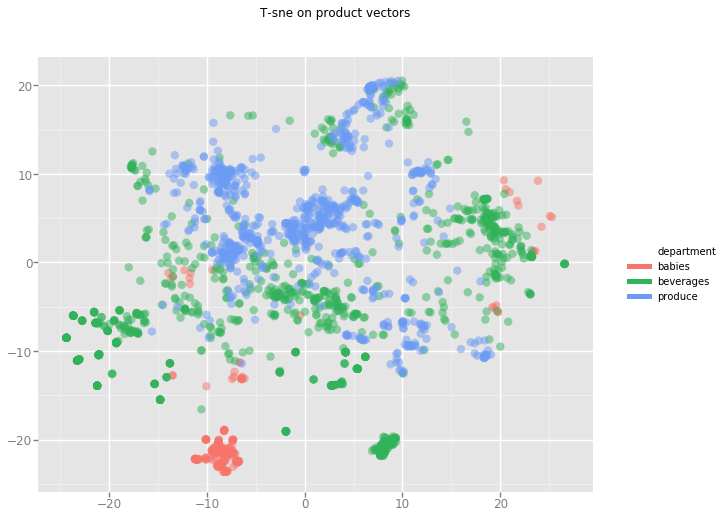

<ggplot: (2932350916528)>

In [91]:
tsne_plot = ggplot(tsne_plot_df, aes(x = "x_tsne", y = "y_tsne", color = "department") ) \
        + geom_point(size = 70, alpha = 0.5) \
        + ggtitle("T-sne on product vectors") \
        + xlab(" ") + ylab(" ")
tsne_plot

----